This notebook explores different ways of considering the driving question of `Last 12 months`, different ways of considering compliance, and different ways of comparing `last 12 months`

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

First read in data and clean data

In [2]:
df1 = pd.read_csv('../data/person1-step-data.csv')
df2 = pd.read_csv('../data/person2-step-data.csv')

def clean_raw_df(df):
    # Convert date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Aggregate data into days
    df = df.groupby('Date').sum().reset_index()
    return df

cleaned_1 = clean_raw_df(df1)
cleaned_2 = clean_raw_df(df2)

Different increments: YTD, weeks, months, whole years
Different metrics: average steps per day, total steps in 12 months
if its average steps per day, we could filter out days, and we'd look at different filter metrics

0.5853797829811537


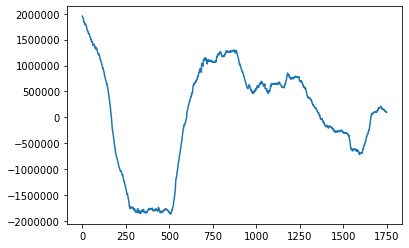

In [3]:
# Main working function
def get_12_mo_comparison(metric, iterator):
    results = []
    for x,y in iterator:
        results.append(metric(x,y))
    return np.array(results)

# Considers days
def decrement_day(dt):
    return dt - timedelta(days = 1)

# Considers months
def decrement_month(dt):
    if dt.month > 1:
        return datetime(year = dt.year, month = dt.month - 1, day = dt.day)
    return datetime(year = dt.year - 1, month = 12, day = dt.day)

# Wraps function so its applied for all args provided
def get_single_return_wrapper(fn):
    def wrapper(*args):
        return [fn(dt) for dt in args]
    return wrapper

# Iterate subsets of time given df, operation to apply after subset, column to extract, and datetime incrementor
def ytd_iter(df, op, col, new_dt):
    start_1 = df['Date'].max()
    end_1 = datetime(year = start_1.year - 1, month = start_1.month, day = start_1.day)
    end_2 = datetime(year = start_1.year - 2, month = start_1.month, day = start_1.day)
    while end_2 >= df['Date'].min():
        y1 = df[(df['Date'] <= start_1) & (df['Date'] > end_1)][col] # Previous 12 months
        y2 = df[(df['Date'] <= end_1) & (df['Date'] > end_2)][col] # The 12 months before that
        yield op(y1), op(y2)
        start_1, end_1, end_2 = new_dt(start_1, end_1, end_2)

# Percentage where we walked more in the last 12 months to the 12 months before
def perc_greater(arr):
    return np.mean(arr>0)

diff = lambda x,y: x-y # Greater than 0 means walked more the last 12 months than the 12 months before

# 12 month comparison, incrementing by day, summing steps in each 12 month
res_1_days_sum = get_12_mo_comparison(diff, ytd_iter(cleaned_1, np.sum, 'Count', get_single_return_wrapper(decrement_day)))
print(perc_greater(res_1_days_sum))
plt.plot(res_1_days_sum)

12 month comparison, incrementing by day, taking average of steps in each 12 month

0.5888063963449457


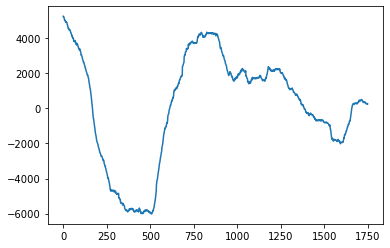

In [4]:
res_1_days_mean = get_12_mo_comparison(diff, ytd_iter(cleaned_1, np.mean, 'Count', get_single_return_wrapper(decrement_day)))
print(perc_greater(res_1_days_mean))
plt.plot(res_1_days_mean)

12 month comparison, incrementing by month, summing steps in each 12 month

0.5862068965517241


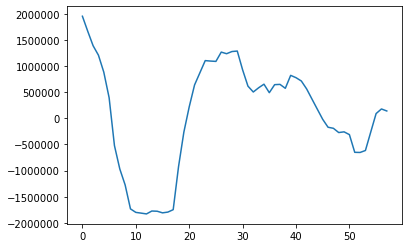

In [5]:
res_1_month_sum = get_12_mo_comparison(diff, ytd_iter(cleaned_1, np.sum, 'Count', get_single_return_wrapper(decrement_month)))
print(perc_greater(res_1_month_sum))
plt.plot(res_1_month_sum)

12 month comparison, incrementing by month, taking average of steps in each 12 month

0.5862068965517241


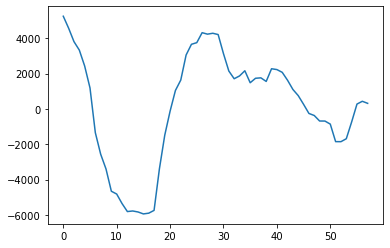

In [6]:
res_1_month_mean = get_12_mo_comparison(diff, ytd_iter(cleaned_1, np.mean, 'Count', get_single_return_wrapper(decrement_month)))
print(perc_greater(res_1_month_mean))
plt.plot(res_1_month_mean)

# Introduction of filters
Here we filter days with fewer than 500 steps (arbitrarily chosen)

12 month comparison, incrementing by day, taking sum of steps in each 12 month, filtering out days with fewer than 500 steps

0.5859508852084523


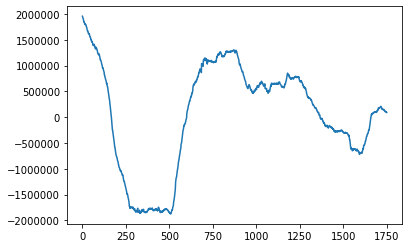

In [7]:
def filter_op(filt, op):
    def fp(arr):
        return op(filt(arr))
    return fp
gt_500 =  lambda x: x[x>500]
res_1_days_f_sum = get_12_mo_comparison(diff, ytd_iter(cleaned_1, filter_op(gt_500, np.sum), 'Count', get_single_return_wrapper(decrement_day)))
print(perc_greater(res_1_days_f_sum))
plt.plot(res_1_days_f_sum)

12 month comparison, incrementing by day, taking average of steps in each 12 month, filtering out days with fewer than 500 steps

0.5922330097087378


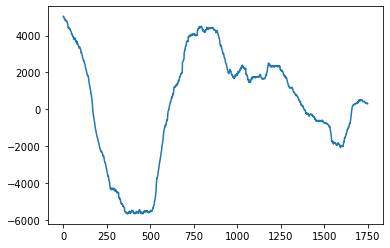

In [8]:
res_1_days_f_mean = get_12_mo_comparison(diff, ytd_iter(cleaned_1, filter_op(gt_500, np.mean), 'Count', get_single_return_wrapper(decrement_day)))
print(perc_greater(res_1_days_f_mean))
plt.plot(res_1_days_f_mean)

12 month comparison, incrementing by month, taking sum of steps in each 12 month, filtering out days with fewer than 500 steps

0.5862068965517241


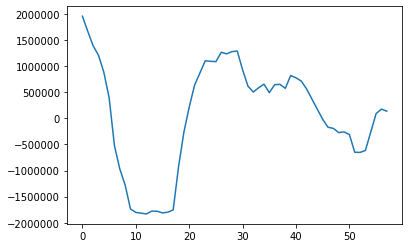

In [9]:
res_1_month_f_sum = get_12_mo_comparison(diff, ytd_iter(cleaned_1, filter_op(gt_500, np.sum), 'Count', get_single_return_wrapper(decrement_month)))
print(perc_greater(res_1_month_f_sum))
plt.plot(res_1_month_f_sum)

12 month comparison, incrementing by month, taking average of steps in each 12 month, filtering out days with fewer than 500 steps

0.603448275862069


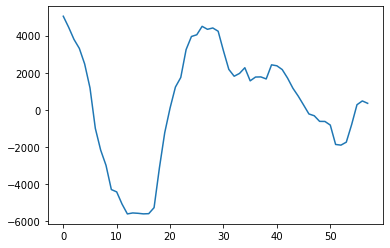

In [10]:
res_1_month_f_mean = get_12_mo_comparison(diff, ytd_iter(cleaned_1, filter_op(gt_500, np.mean), 'Count', get_single_return_wrapper(decrement_month)))
print(perc_greater(res_1_month_f_mean))
plt.plot(res_1_month_f_mean)